Code repurposed from Kaggle [https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-cryptocurrencies]

## import dependencies

In [1]:
import pandas as pd
import pandas_datareader as web
import numpy as np
from pathlib import Path
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from yahoo_fin.stock_info import get_data

%matplotlib inline

## load and inspect data

In [2]:
crypto_currency = 'XMR'
against_currency = 'USD'

start = dt.datetime(2014,1,1)
end = dt.datetime.now()

base_df = get_data(f'{crypto_currency}-{against_currency}', start, end, index_as_date = True, interval = '1d')
base_df

,open,high,low,close,adjclose,volume,ticker
2014-09-16,1.841200,1.898070,1.647920,1.768350,1.768350,291633.0,XMR-USD
2014-09-17,1.741810,1.741810,1.504760,1.569280,1.569280,253082.0,XMR-USD
2014-09-18,1.567750,1.590900,1.376020,1.454370,1.454370,171739.0,XMR-USD
2014-09-19,1.442590,1.567370,1.174460,1.271210,1.271210,362626.0,XMR-USD
2014-09-20,1.267670,1.414170,1.174950,1.274150,1.274150,239591.0,XMR-USD
...,...,...,...,...,...,...,...
2021-07-03,214.839951,224.909012,213.023071,219.841415,219.841415,169785754.0,XMR-USD
2021-07-04,219.961960,220.354187,206.502609,214.464996,214.464996,170985179.0,XMR-USD
2021-07-05,214.470718,222.137131,212.296829,222.137131,222.137131,167861959.0,XMR-USD
2021-07-06,221.855377,231.428772,214.514664,214.850555,214.850555,187227277.0,XMR-USD


In [3]:
base_df['spread'] = base_df.high - base_df.low
base_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2487 entries, 2014-09-16 to 2021-07-08
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      2483 non-null   float64
 1   high      2483 non-null   float64
 2   low       2483 non-null   float64
 3   close     2483 non-null   float64
 4   adjclose  2483 non-null   float64
 5   volume    2483 non-null   float64
 6   ticker    2487 non-null   object 
 7   spread    2483 non-null   float64
dtypes: float64(7), object(1)
memory usage: 174.9+ KB


## Plot the closing value of Monero over time

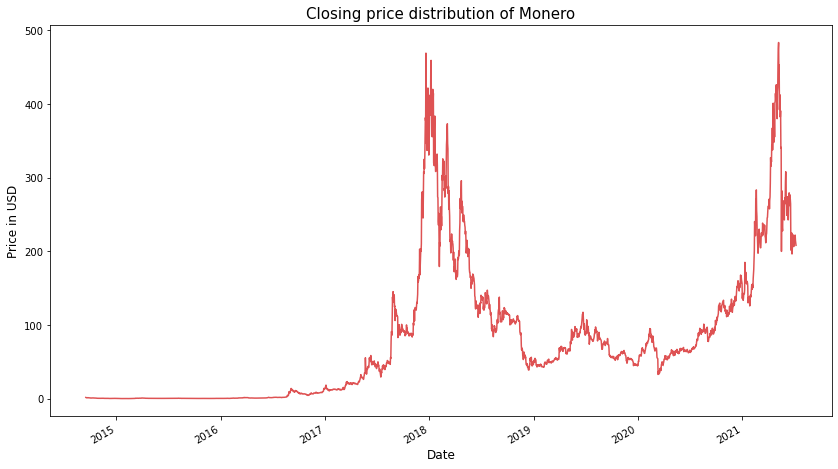

In [4]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14,8))

sns.lineplot(y = base_df.close.values, x=base_df.index.values, alpha=0.8, color=color[3])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Closing price distribution of Monero", fontsize=15)
plt.show()

Text(0.5, 1.0, 'Daily price spread of Monero')

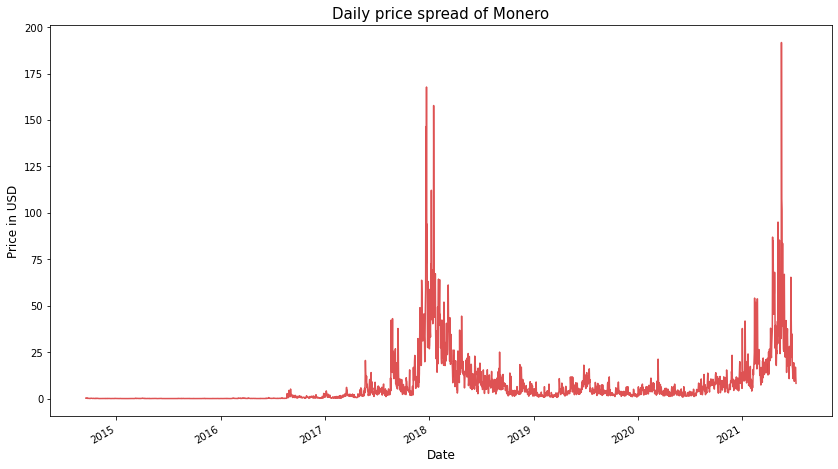

In [5]:
fig, ax = plt.subplots(figsize=(14,8))

sns.lineplot(y = base_df.spread.values, x=base_df.index.values, alpha=0.8, color=color[3])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Daily price spread of Monero", fontsize=15)

## Candlestick chart

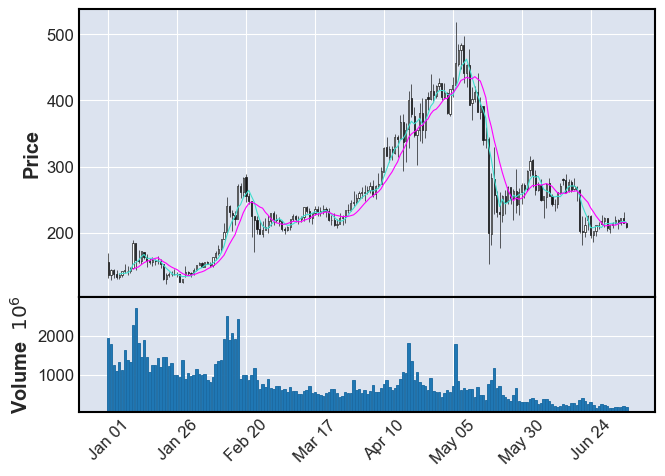

In [11]:
import matplotlib.ticker as mticker
import mplfinance as mpf

temp_base_df = base_df.copy(deep=False)

temp_base_df = temp_base_df.drop(['spread'], axis=1)
mpf.plot(temp_base_df.loc['2021-1-1':], type='candle', mav=(5,10), volume=True)

## Future Price Prediction

In [7]:
from fbprophet import Prophet

In [8]:
price_predict_df = base_df['close'].copy(deep=False).reset_index()
price_predict_df.columns = ["ds", "y"]
#price_predict_df = price_predict_df[price_predict_df['ds']>'2020-6-1']
price_predict_df

,ds,y
0,2014-09-16,1.768350
1,2014-09-17,1.569280
2,2014-09-18,1.454370
3,2014-09-19,1.271210
4,2014-09-20,1.274150
...,...,...
2482,2021-07-03,219.841415
2483,2021-07-04,214.464996
2484,2021-07-05,222.137131
2485,2021-07-06,214.850555


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
2505,2021-08-03,279.596155,246.355397,313.090838
2506,2021-08-04,280.221183,247.129549,313.967190
2507,2021-08-05,279.297843,248.700411,312.608205
2508,2021-08-06,280.028513,248.172856,315.637955
2509,2021-08-07,280.548454,245.701263,316.271779


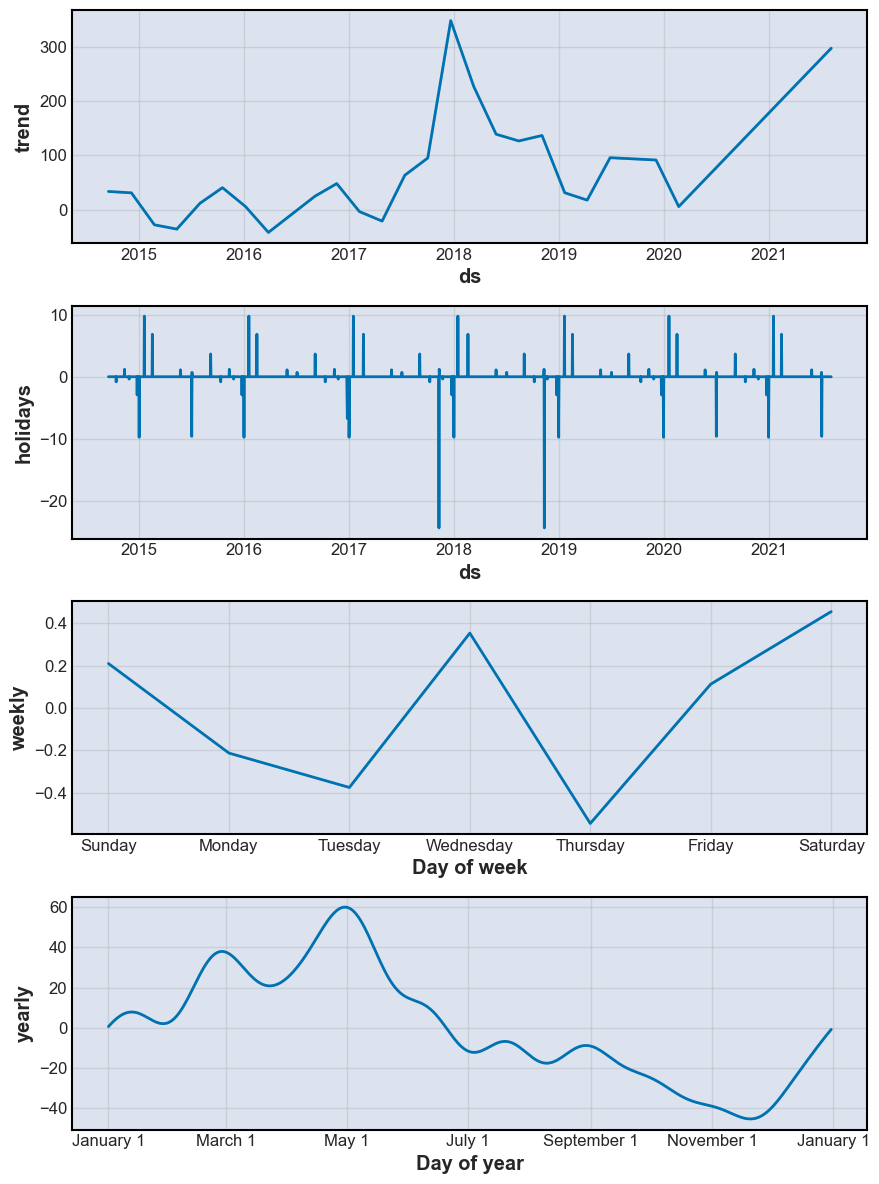

In [9]:
m = Prophet(changepoint_prior_scale=.7)
m.add_country_holidays(country_name='US')
#m.add_country_holidays(country_name='CN')
m.fit(price_predict_df);
m.train_holiday_names

future = m.make_future_dataframe(periods=30)

forecast = m.predict(future)
fig = m.plot_components(forecast)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

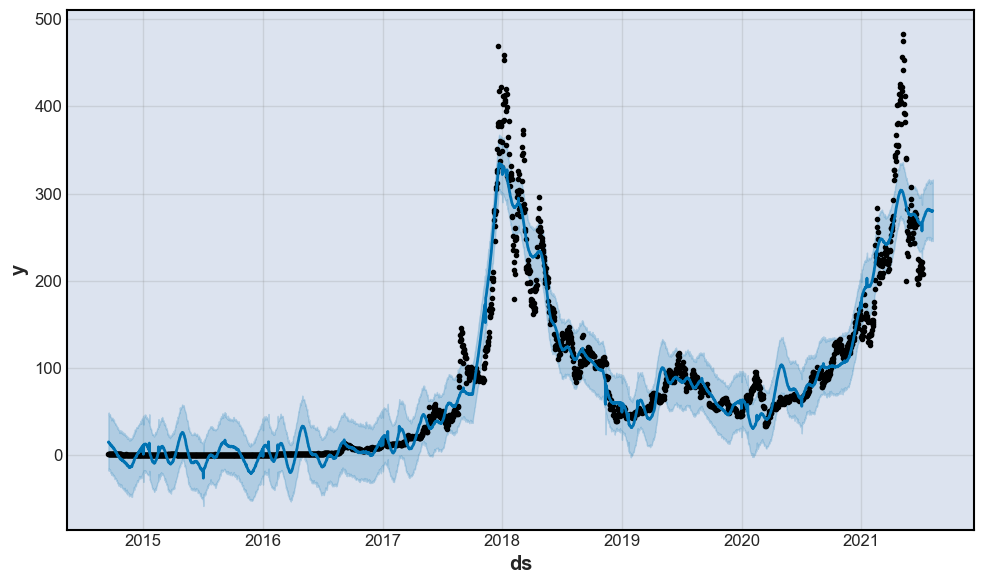

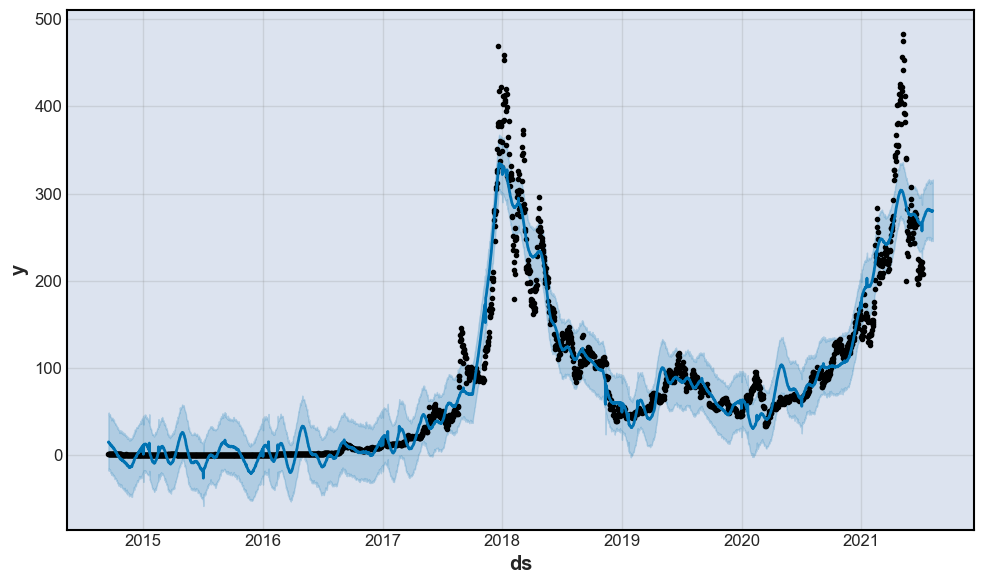

In [10]:
m.plot(forecast)